In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests 
from bs4 import BeautifulSoup

## 1. Import raw data into a DataFrame

In [2]:

# Please download the dataset manually from:
# European Environment Agency (EEA):
# https://www.eea.europa.eu/data-and-maps/data/co2-cars-emission-20
# Save it as "2023_Cars_Raw.csv" inside the "data" folder.

# file_path = "data/2022_Cars_Raw.csv"
# cars = pd.read_csv(file_path)
# Cars_df = cars.copy()


In [3]:
cars = pd.read_csv("C:/Users/Fariba/Zahra/2022_Cars_Raw.csv") 
Cars_df = cars.copy()

In [4]:
Cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3769313 entries, 0 to 3769312
Data columns (total 37 columns):
 #   Column                                                                                      Dtype  
---  ------                                                                                      -----  
 0   Vehicle Identifier                                                                          int64  
 1   OBFCM data source                                                                           object 
 2   OBFCM ReportingPeriod                                                                       int64  
 3   Total fuel consumed (lifetime) (l)                                                          float64
 4   Total distance travelled (lifetime) (km)                                                    float64
 5   Total distance travelled in charge depleting operation with engine off (lifetime) (km)      float64
 6   Total distance travelled in charge depleti

In [5]:
Cars_df.isna().sum()

Vehicle Identifier                                                                                  0
OBFCM data source                                                                                   0
OBFCM ReportingPeriod                                                                               0
Total fuel consumed (lifetime) (l)                                                                  0
Total distance travelled (lifetime) (km)                                                            1
Total distance travelled in charge depleting operation with engine off (lifetime) (km)        2114167
Total distance travelled in charge depleting operation with engine running (lifetime) (km)    2120227
Total distance travelled in driver-selectable charge increasing operation (lifetime) (km)     2069067
Total fuel consumed in charge depleting operation (lifetime) (l)                              2072192
Total fuel consumed in driver-selectable charge increasing operation (lifetime) (l

In [6]:
Cars_df.shape

(3769313, 37)

In [7]:
Cars_df['Ft'].value_counts()

Ft
PETROL             1237283
petrol              897639
DIESEL              701519
diesel              356466
PETROL/ELECTRIC     309436
petrol/electric     154702
DIESEL/ELECTRIC      44964
diesel/electric      23292
e85                  19403
lpg                  12295
LPG                   6195
E85                   4342
NG-BIOMETHANE         1599
ng                     174
electric                 2
ELECTRIC                 1
UNKNOWN                  1
Name: count, dtype: int64

## 2. Classify Vehicles 

In [8]:
def classify_vehicle(row):
    
    fuel = str(row.get("Ft", "")).strip().lower()                
    grid_energy = row.get("Total grid energy into the battery (lifetime) (kWh)", 0)
    fuel_consumed = row.get("Total fuel consumed (lifetime) (l)", 0)

    if fuel_consumed == 0 and grid_energy > 0:                   # Battery EV: no fuel consumed, but grid energy > 0
        return "Battery EV"

    elif "petrol/electric" in fuel and grid_energy > 0:          # Plug-in Hybrid (PHEV): both fuel type petrol/electric and grid charging
        return "Plug-in Hybrid (PHEV)"

    elif "petrol" in fuel and fuel_consumed > 0:                 # Petrol: fuel type petrol, consuming fuel
        return "Petrol"

    else:
        return "Other"


In [9]:
Cars_df["vehicle_category"] = Cars_df.apply(classify_vehicle, axis=1)

In [10]:
Cars_df["vehicle_category"].value_counts()

vehicle_category
Petrol                   2204222
Other                    1178907
Plug-in Hybrid (PHEV)     385682
Battery EV                   502
Name: count, dtype: int64

## 3. Build a dataframe for Petrol & PHEV category

In [11]:
petrol_df = Cars_df[Cars_df["vehicle_category"] == "Petrol"]
phev_df = Cars_df[Cars_df["vehicle_category"] == "Plug-in Hybrid (PHEV)"]

In [12]:
pd.set_option('display.max_columns' , 50)

# 4. Working on petrol_df

In [13]:
petrol_df.shape

(2204222, 38)

In [14]:
petrol_df = petrol_df[[
    "Country",
    "Mh",
    "Mk",
    "M (kg)",
    "Mt",
    "Ec (cm3)",
    "Ep (KW)",
    "Fuel consumption",
    "Total fuel consumed (lifetime) (l)",
    "Total distance travelled (lifetime) (km)",
    "VFN",
    "Va",
    "Ve",
    "Year",
    "OBFCM ReportingPeriod",
    "Ewltp (g/km)",
    "Erwltp (g/km)"
]]

In [15]:
petrol_df.isna().sum()

Country                                          0
Mh                                               0
Mk                                               0
M (kg)                                           0
Mt                                            6632
Ec (cm3)                                        46
Ep (KW)                                       7903
Fuel consumption                            243784
Total fuel consumed (lifetime) (l)               0
Total distance travelled (lifetime) (km)         1
VFN                                           2619
Va                                               0
Ve                                            1315
Year                                             0
OBFCM ReportingPeriod                            0
Ewltp (g/km)                                    26
Erwltp (g/km)                               518085
dtype: int64

### Duplicate Handling in petrol_df

In [16]:
petrol_df.drop_duplicates().shape

(2116969, 17)

In [17]:
# remove 87,253 duplicates
petrol_df = petrol_df.drop_duplicates()
petrol_df.shape

(2116969, 17)

### Null Handling in petrol_df

In [18]:
petrol_df.isna().sum()

Country                                          0
Mh                                               0
Mk                                               0
M (kg)                                           0
Mt                                            4880
Ec (cm3)                                        44
Ep (KW)                                       7869
Fuel consumption                            242798
Total fuel consumed (lifetime) (l)               0
Total distance travelled (lifetime) (km)         1
VFN                                           2461
Va                                               0
Ve                                            1287
Year                                             0
OBFCM ReportingPeriod                            0
Ewltp (g/km)                                    26
Erwltp (g/km)                               509221
dtype: int64

In [19]:
petrol_df = petrol_df.dropna(subset=("Total distance travelled (lifetime) (km)"))

### Add total lifecycle emissions (g/km) for each vehicle in petrol_df
- Well-to-Tank emission (600 g/lit)
- Tank-to-Wheel emission (2320 g/lit)

In [20]:
# calculate the real fuel consumption (l/km)
petrol_df.loc[:,"real_fuel(l/km)"] = petrol_df["Total fuel consumed (lifetime) (l)"] / petrol_df["Total distance travelled (lifetime) (km)"]

# Tank-to-Wheel emissions (direct from exhaust)
#petrol_df.loc[:, "CO2_TTW_gpkm"] = petrol_df.loc[:,"real_fuel_per_km"] * 2320               

# Well-to-Tank emissions (fuel production, refining, transport)
#petrol_df.loc[:,"CO2_WTT_gpkm"] = petrol_df.loc[:,"real_fuel_per_km"] * 580

# Well-to-Wheel emissions (total lifecycle emissions) (2320 + 600)
petrol_df.loc[:,"CO2_WTW(kg/km)"] = petrol_df.loc[:,"real_fuel(l/km)"] * 2.900

In [21]:
petrol_df.sample(4)

,Country,Mh,Mk,M (kg),Mt,Ec (cm3),Ep (KW),Fuel consumption,Total fuel consumed (lifetime) (l),Total distance travelled (lifetime) (km),VFN,Va,Ve,Year,OBFCM ReportingPeriod,Ewltp (g/km),Erwltp (g/km),real_fuel(l/km),CO2_WTW(kg/km)
3417832,IT,FIAT GROUP,LANCIA,1055,1140.0,999.0,52.0,5.1,516.40,10850.7,IP-03_312_0282-ZFA-1,YYD1B,EY9FM,2021,2022,117.0,1.28,0.047591,0.138015
1342250,IT,STELLANTIS EUROPE,FIAT,1045,1124.0,999.0,52.0,4.8,0.87,4.4,IP-03_312_0290-ZFA-1,PYD1B,EP18ANM,2022,2022,109.0,1.28,0.197727,0.573409
3698096,PL,VOLKSWAGEN,VOLKSWAGEN VW,1541,1730.0,1498.0,110.0,5.6,2768.20,29076.8,IP-MQB37AS_A2_0813-WVW-1,ACDPCAX0,FD7FD7GC008N5N3TVR24BI1ASA0M1IS,2021,2022,162.0,1.14,0.095203,0.276089
2679740,PL,TOYOTA,TOYOTA,1420,1509.0,1798.0,72.0,4.5,1279.81,30366.3,IP-0141-JT1-1,ZWE211(H),ZWE211L-DHXNBW(1E),2021,2022,102.0,0.90,0.042146,0.122223


### Replace the complete name of countries with codes

In [22]:
petrol_df['Country'].unique()

array(['ES', 'DE', 'IT', 'PL', 'PT', 'FR', 'SI', 'RO', 'BG', 'DK', 'SE',
       'LU', 'AT', 'EE', 'FI', 'LV', 'SK', 'LT', 'CZ', 'BE', 'HU', 'NL',
       'CY', 'NO', 'GR', 'IE', 'HR', 'IS', 'MT'], dtype=object)

In [23]:
country_names = {
    "NL": "Netherlands",
    "PT": "Portugal",
    "PL": "Poland",
    "RO": "Romania",
    "SK": "Slovakia",
    "GR": "Greece",
    "DE": "Germany",
    "IT": "Italy",
    "ES": "Spain",
    "BE": "Belgium",
    "FR": "France",
    "DK": "Denmark",
    "HU": "Hungary",
    "LT": "Lithuania",
    "AT": "Austria",
    "CZ": "Czech Republic",
    "SE": "Sweden",
    "CY": "Cyprus",
    "LU": "Luxembourg",
    "MT": "Malta",
    "BG": "Bulgaria",
    "FI": "Finland",
    "HR": "Croatia",
    "IE": "Ireland",
    "EE": "Estonia",
    "SI": "Slovenia",
    "LV": "Latvia",
    "NO": "Norway",
    "IS": "Iceland"
}
petrol_df.loc[:,"Country"] = petrol_df.loc[:,"Country"].map(country_names)

In [24]:
petrol_df.sample(3)

,Country,Mh,Mk,M (kg),Mt,Ec (cm3),Ep (KW),Fuel consumption,Total fuel consumed (lifetime) (l),Total distance travelled (lifetime) (km),VFN,Va,Ve,Year,OBFCM ReportingPeriod,Ewltp (g/km),Erwltp (g/km),real_fuel(l/km),CO2_WTW(kg/km)
968579,Germany,VOLVO,VOLVO,1812,1914.0,1477.0,132.0,2.1,1.00,3.0,IP-2019_536BBF-YV1-1,XZBB,XZBBVF0,2022,2022,47.0,NaN,0.333333,0.966667
3538359,Italy,VOLKSWAGEN,VOLKSWAGEN,1252,1374.0,999.0,70.0,4.8,528.37,8350.1,IP-MQB27SZ_A3_0537-WVW-1,DLACACX05,FM5FM5DF0094BI1AA0I,2021,2022,131.0,1.13,0.063277,0.183504
915050,France,OPEL AUTOMOBILE,OPEL,1280,1423.0,1199.0,96.0,6.1,287.00,4632.0,IP-HNS____AT6_1430-W0V-0,EA023DB12,BE1VABPAZA5,2022,2022,137.0,2.12,0.061960,0.179685


In [25]:
petrol_df[petrol_df["Total fuel consumed (lifetime) (l)"]==0].shape

(0, 19)

In [26]:
petrol_df[petrol_df["Total distance travelled (lifetime) (km)"]==0].shape

(1207, 19)

In [27]:
petrol_df = petrol_df[petrol_df["Total distance travelled (lifetime) (km)"]!=0]

In [28]:
# Group by country for specific countries

selected_countries = ['France', 'Sweden', 'Spain', 'Germany', 'Poland','Italy']

selected_petrol_df = petrol_df[petrol_df['Country'].isin(selected_countries)]

## Handling outliers in petrol_df after grouping by country

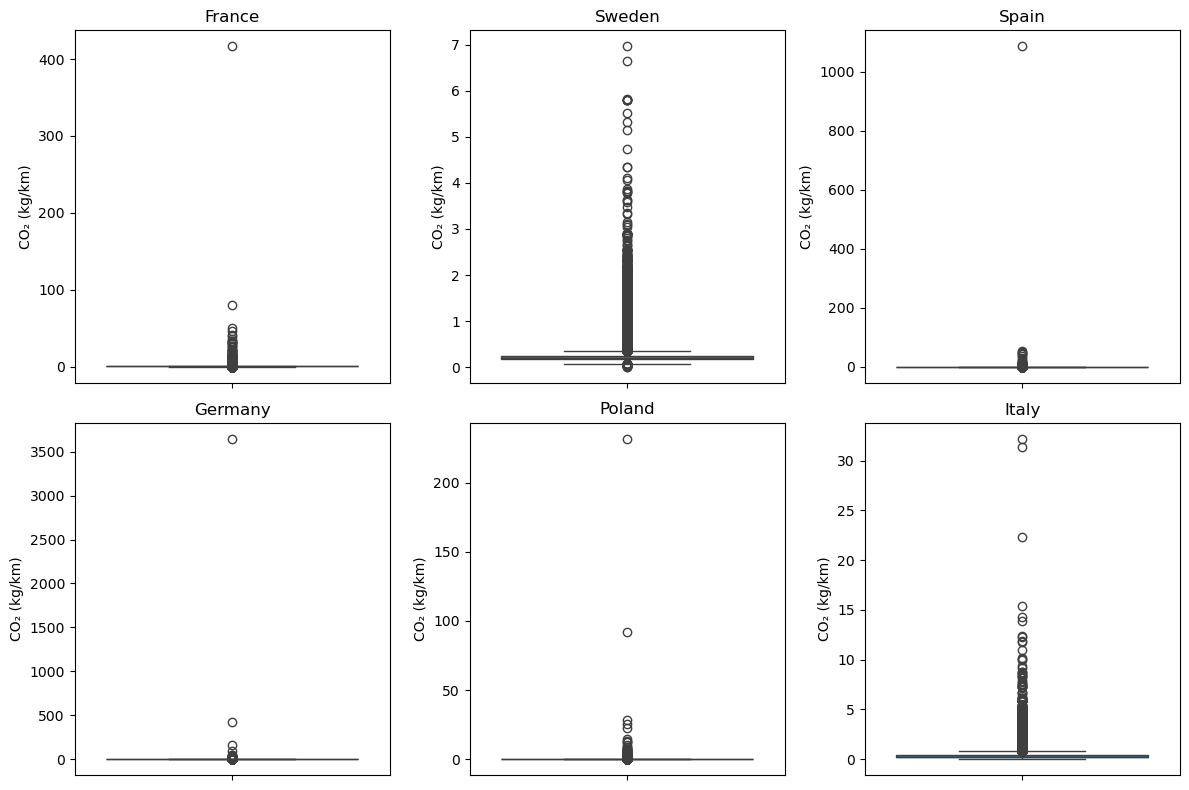

In [29]:
plt.figure(figsize=(12, 8))

for i, country in enumerate(selected_countries):
    plt.subplot(2, 3, i+1)  
    country_data = selected_petrol_df[selected_petrol_df['Country'] == country]
    sns.boxplot(data=country_data, y="CO2_WTW(kg/km)")
    plt.title(country)
    plt.ylabel("CO₂ (kg/km)")

plt.tight_layout()
plt.show()


In [30]:
# removing outliers of three CO2 columns

def remove_outliers(df,columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_whisker = Q1 - 1.5 * IQR
        upper_whisker = Q3 + 1.5 * IQR
        df_clean = df_clean.loc[(df_clean[column] >= lower_whisker) & (df_clean[column] <= upper_whisker)]
    return df_clean

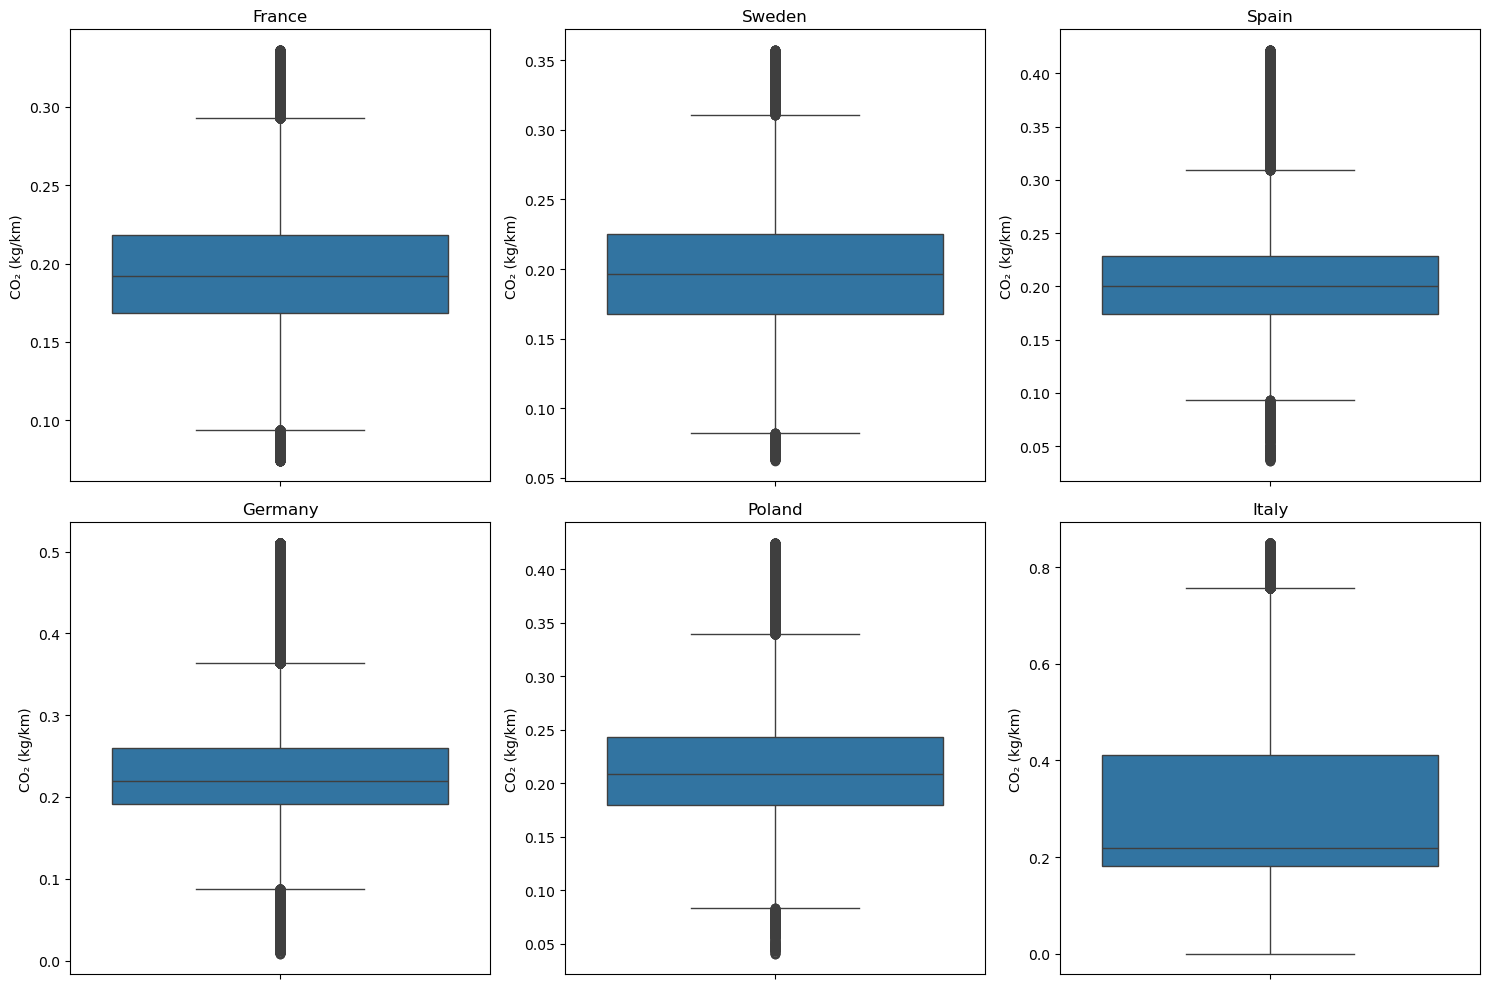

In [31]:
columns_to_clean = ["CO2_WTW(kg/km)"]  

# Create a clean dataframe by combining cleaned data from each country after removing outliers
cleaned_all_df = pd.DataFrame()

for country in selected_countries:
    country_df = selected_petrol_df[selected_petrol_df['Country'] == country]
    cleaned_country_df = remove_outliers(country_df, columns_to_clean)
    cleaned_all_df = pd.concat([cleaned_all_df, cleaned_country_df], ignore_index=True)

# Plot separate boxplots for each country
plt.figure(figsize=(15, 10))

for i, country in enumerate(selected_countries):
    plt.subplot(2, 3, i+1)           
    country_data = cleaned_all_df[cleaned_all_df['Country'] == country]
    sns.boxplot(data=country_data, y="CO2_WTW(kg/km)")
    plt.title(country)
    plt.ylabel("CO₂ (kg/km)")

plt.tight_layout()
plt.show()



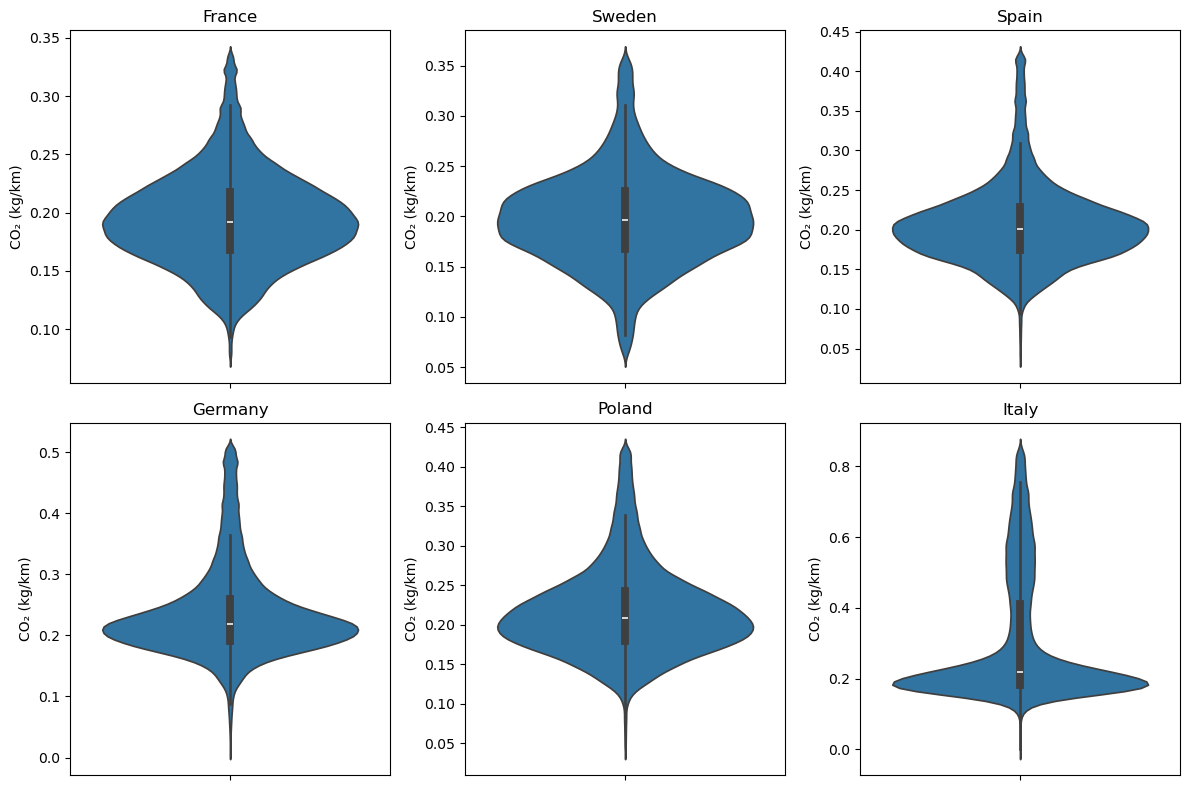

In [32]:
# Violin plot for each country

plt.figure(figsize=(12, 8))

for i, country in enumerate(selected_countries):
    plt.subplot(2, 3, i+1)  
    country_data = cleaned_all_df[cleaned_all_df['Country'] == country]
    sns.violinplot(data=country_data, y="CO2_WTW(kg/km)")
    plt.title(country)
    plt.ylabel("CO₂ (kg/km)")

plt.tight_layout()
plt.show()


In [33]:
petrol_df_clean = cleaned_all_df.copy()

In [34]:
cleaned_all_df['Country'].value_counts()

Country
Germany    405168
Italy      385297
France     309302
Spain      163372
Poland     115055
Sweden      33448
Name: count, dtype: int64

### Further Visullisation

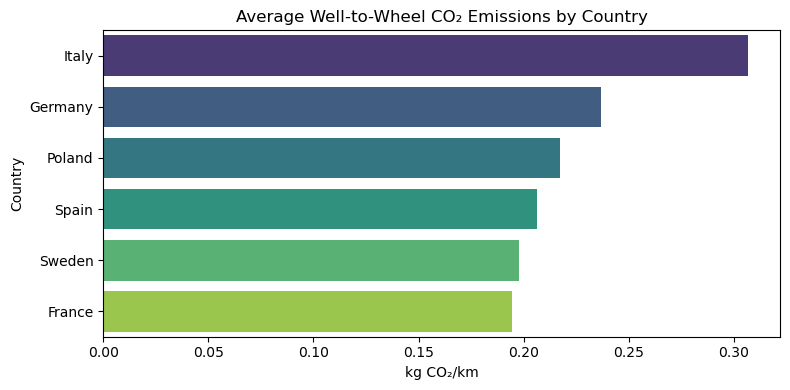

In [35]:
# Average CO₂ Emissions by Country for top 10 countries

country_avg = (petrol_df_clean.groupby('Country')[['CO2_WTW(kg/km)']].mean()
            .sort_values(by='CO2_WTW(kg/km)', ascending=False)
            .reset_index())

plt.figure(figsize=(8, 4))
sns.barplot(data=country_avg, y='Country', x='CO2_WTW(kg/km)', palette='viridis', hue='Country')
plt.title('Average Well-to-Wheel CO₂ Emissions by Country')
plt.xlabel('kg CO₂/km')
plt.tight_layout()
plt.show()

In [36]:
# del country_avg

In [37]:
petrol_df_clean.isna().sum()

Country                                          0
Mh                                               0
Mk                                               0
M (kg)                                           0
Mt                                            1231
Ec (cm3)                                        35
Ep (KW)                                        726
Fuel consumption                            110705
Total fuel consumed (lifetime) (l)               0
Total distance travelled (lifetime) (km)         0
VFN                                            533
Va                                               0
Ve                                               0
Year                                             0
OBFCM ReportingPeriod                            0
Ewltp (g/km)                                     3
Erwltp (g/km)                               329685
real_fuel(l/km)                                  0
CO2_WTW(kg/km)                                   0
dtype: int64

In [38]:
petrol_df_clean = petrol_df_clean.drop(columns=['Fuel consumption','Erwltp (g/km)'])

In [39]:
temp_petrol_df = petrol_df_clean.dropna()

In [40]:
temp_petrol_df.loc[:,'Ewltp (g/km)'] = temp_petrol_df.loc[:,'Ewltp (g/km)']/1000
temp_petrol_df = temp_petrol_df.rename(columns={'Ewltp (g/km)' : 'Ewltp (kg/km)'})

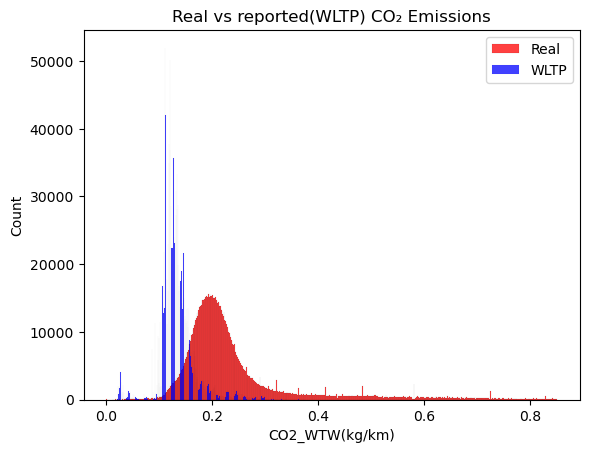

In [41]:
## comparing Ewltp with real emission

sns.histplot(data = temp_petrol_df, x='CO2_WTW(kg/km)', color='red', label='Real')
sns.histplot(data = temp_petrol_df, x='Ewltp (kg/km)', color='blue', label='WLTP')
plt.legend()
plt.title('Real vs reported(WLTP) CO₂ Emissions')
plt.show()


---

# 5. Working on Plug-in Hybrid (phev_df)

In [42]:
phev_df.shape

(385682, 38)

### Duplicate Handling

In [43]:
phev_df.drop_duplicates().shape

(385682, 38)

### Null Handling

In [44]:
phev_df = phev_df[[
    "Year",
    "OBFCM ReportingPeriod",
    "M (kg)",
    "Mt",
    "Country",
    "Mh",
    "Mk",
    "VFN",
    "Va",
    "Ve",  
    "Ec (cm3)",
    "Ep (KW)",
    "Z (Wh/km)",
    "Fuel consumption",
    "Electric range (km)",
    "Total fuel consumed (lifetime) (l)",
    "Total distance travelled (lifetime) (km)",
    "Total distance travelled in charge depleting operation with engine off (lifetime) (km)",
    "Total distance travelled in charge depleting operation with engine running (lifetime) (km)",
    "Total distance travelled in driver-selectable charge increasing operation (lifetime) (km)",
    "Total fuel consumed in charge depleting operation (lifetime) (l)",
    "Total fuel consumed in driver-selectable charge increasing operation (lifetime) (l)",
    "Total grid energy into the battery (lifetime) (kWh)",
    "Ewltp (g/km)",
    "Erwltp (g/km)"    
]]

In [45]:
phev_df.isna().sum()

Year                                                                                               0
OBFCM ReportingPeriod                                                                              0
M (kg)                                                                                             0
Mt                                                                                              1372
Country                                                                                            0
Mh                                                                                                 0
Mk                                                                                                 0
VFN                                                                                             3786
Va                                                                                                 0
Ve                                                                                         

In [46]:
phev_df = phev_df.drop(columns=['Erwltp (g/km)'])

In [47]:
phev_df = phev_df.drop(columns=['Fuel consumption'])

In [48]:
phev_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 385682 entries, 20 to 3769312
Data columns (total 23 columns):
 #   Column                                                                                      Non-Null Count   Dtype  
---  ------                                                                                      --------------   -----  
 0   Year                                                                                        385682 non-null  int64  
 1   OBFCM ReportingPeriod                                                                       385682 non-null  int64  
 2   M (kg)                                                                                      385682 non-null  int64  
 3   Mt                                                                                          384310 non-null  float64
 4   Country                                                                                     385682 non-null  object 
 5   Mh                               

In [49]:
phev_df = phev_df.dropna(subset=('Z (Wh/km)','Electric range (km)'))

In [50]:
phev_df.isna().sum()

Year                                                                                              0
OBFCM ReportingPeriod                                                                             0
M (kg)                                                                                            0
Mt                                                                                             1056
Country                                                                                           0
Mh                                                                                                0
Mk                                                                                                0
VFN                                                                                            3556
Va                                                                                                0
Ve                                                                                                0


In [51]:
phev_df = phev_df[phev_df['Total distance travelled (lifetime) (km)']!=0]

---

### Replace the complete name of countries with codes

In [52]:
country_names = {
    "NL": "Netherlands",
    "PT": "Portugal",
    "PL": "Poland",
    "RO": "Romania",
    "SK": "Slovakia",
    "GR": "Greece",
    "DE": "Germany",
    "IT": "Italy",
    "ES": "Spain",
    "BE": "Belgium",
    "FR": "France",
    "DK": "Denmark",
    "HU": "Hungary",
    "LT": "Lithuania",
    "AT": "Austria",
    "CZ": "Czech Republic",
    "SE": "Sweden",
    "CY": "Cyprus",
    "LU": "Luxembourg",
    "MT": "Malta",
    "BG": "Bulgaria",
    "FI": "Finland",
    "HR": "Croatia",
    "IE": "Ireland",
    "EE": "Estonia",
    "SI": "Slovenia",
    "LV": "Latvia",
    "NO": "Norway",
    "IS": "Iceland"
}
phev_df.loc[:,"Country"] = phev_df.loc[:,"Country"].map(country_names)

---

## Calculate CO2 emission in multiple segments for Phev
### 1. CO2 emission of fuel (including refine, transport and consumption)

In [53]:
# calculate the real fuel consumption (l/km)
phev_df.loc[:,"real_fuel(l/km)"] = phev_df["Total fuel consumed (lifetime) (l)"] / phev_df["Total distance travelled (lifetime) (km)"]

# Tank-to-Wheel emissions (direct from exhaust)
#phev_df.loc[:, "CO2_TTW_gpkm"] = phev_df.loc[:,"real_fuel_per_km"] * 2320               

# Well-to-Tank emissions (fuel production, refining, transport)
#phev_df.loc[:,"CO2_WTT_gpkm"] = phev_df.loc[:,"real_fuel_per_km"] * 580

# Well-to-Wheel emissions (total lifecycle emissions) (2320 + 600)
phev_df.loc[:,"CO2_WTW(kg/km)"] = phev_df.loc[:,"real_fuel(l/km)"] * 2.900

### 2. CO2 emission of Electricity Production

In [54]:
# Please download the dataset manually from:
# Our World in Data (OWID): https://ourworldindata.org/grapher/carbon-intensity-electricity
# Save it as "carbon-intensity-electricity.csv" inside the "data" folder.

# file_path = "data/carbon-intensity-electricity.csv"
# carbon_df = pd.read_csv(file_path)
# carbon_df.head()

In [55]:
# read data from Our World in Data for CO2 emission of electricity production in each country in EU

Electricity_Emission = pd.read_csv("C:/Users/Fariba/Zahra/Final_Project_Data/carbon-intensity-electricity.csv") 
electricity_emission_df = Electricity_Emission.copy()

In [56]:
electricity_emission_df.sample(5)

,Entity,Code,Year,Carbon intensity of electricity - gCO2/kWh,time
159,South Africa,ZAF,2022.0,729.72516,2022
191,Zambia,ZMB,2022.0,111.96713,2022
19,Bolivia,BOL,2022.0,485.86118,2022
46,Djibouti,DJI,2022.0,450.00000,2022
23,Brunei,BRN,2022.0,892.85720,2022


In [57]:
code3_to_code2 = {"POL":"PL","DEU":"DE","ITA":"IT","BEL":"BE","PRT":"PT","IRL":"IE","FRA":"FR",
                  "GRC":"GR","ESP":"ES","ROU":"RO","NLD":"NL","FIN":"FI","CZE":"CZ","DNK":"DK",
                  "SWE":"SE","LUX":"LU","AUT":"AT","ISL":"IS","HRV":"HR","HUN":"HU","SVN":"SI",
                  "LTU":"LT","EST":"EE","BGR":"BG","MLT":"MT","NOR":"NO","SVK":"SK","LVA":"LV","CYP":"CY"}

electricity_emission_df = electricity_emission_df.copy()
electricity_emission_df["Code"] = electricity_emission_df["Code"].map(code3_to_code2)

wanted_codes = ['PL','DE','IT','BE','PT','IE','FR','GR','ES','RO','NL',
                'FI','CZ','DK','SE','LU','AT','IS','HR','HU','SI','LT',
                'EE','BG','MT','NO','SK','LV','CY']



In [58]:
electricity_emission_df_EU = electricity_emission_df[electricity_emission_df["Code"].isin(wanted_codes)][['Code','Entity','Carbon intensity of electricity - gCO2/kWh']]
electricity_emission_df_EU.sample(5)

,Code,Entity,Carbon intensity of electricity - gCO2/kWh
137,PL,Poland,732.97870
138,PT,Portugal,225.33994
107,MT,Malta,500.00000
42,CY,Cyprus,555.13306
8,AT,Austria,141.06340


In [59]:
electricity_emission_df_EU.shape

(29, 3)

In [60]:
electricity_emission_df_EU.loc[:,"Carbon intensity of electricity - gCO2/kWh"] = electricity_emission_df_EU.loc[:,"Carbon intensity of electricity - gCO2/kWh"]/1000

In [61]:
electricity_emission_df_EU = electricity_emission_df_EU.rename(
                                     columns={"Carbon intensity of electricity - gCO2/kWh": "CO2_intensity(kg/kwh)",
                                             "Entity":"Country"})

In [62]:
electricity_emission_df_EU.sample(5)

,Code,Country,CO2_intensity(kg/kwh)
95,LV,Latvia,0.135189
76,HU,Hungary,0.228899
100,LT,Lithuania,0.180693
60,FR,France,0.078550
120,NL,Netherlands,0.326071


In [63]:
# merging two dataframe to create a column for CO2_intensity in phev_df

phev_df = phev_df.merge(electricity_emission_df_EU,
                        left_on="Country",   
                        right_on="Country",     
                        how="left")


In [64]:
# calculate the real electricity consumption (kwh/km)

phev_df.loc[:, "real_electricity(kwh/km)"] = (phev_df["Total grid energy into the battery (lifetime) (kWh)"] /
                                            phev_df["Total distance travelled (lifetime) (km)"])

phev_df.loc[:,"CO2_by_electricity(kg/km)"] = phev_df.loc[:, "real_electricity(kwh/km)"] * phev_df.loc[:, "CO2_intensity(kg/kwh)"]

In [65]:
# total CO2 emission while driving

phev_df.loc[:,"Total_CO2_driving(kg/km)"] = phev_df.loc[:,"CO2_WTW(kg/km)"] + phev_df.loc[:,"CO2_by_electricity(kg/km)"]

### 3. CO2 emission of battery production

In [66]:
# Estimate battery capacity (kWh) using energy consumption per km (Wh/km) and electric range (km)

phev_df["Battery_capacity_kWh"] = (phev_df["Z (Wh/km)"] * phev_df["Electric range (km)"] / 1000)


In [67]:
# Estimate CO2 emissions from battery production (kg CO2)

phev_df["Battery_CO2(kg)"] = (phev_df["Battery_capacity_kWh"] * 80)


In [68]:
col = ['Battery_CO2(kg)']
remove_outliers(phev_df,col).shape

(337061, 32)

In [69]:
phev_df.shape

(359504, 32)

<Axes: xlabel='Battery_CO2(kg)'>

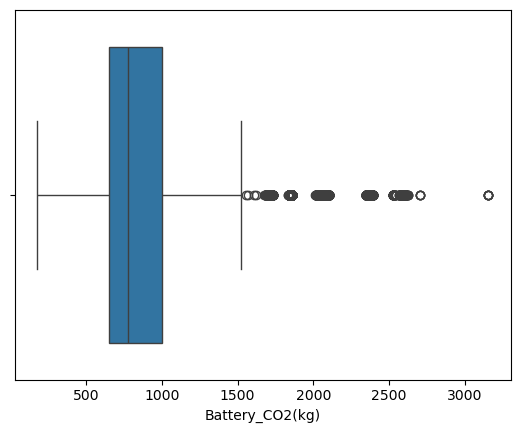

In [70]:
sns.boxplot(data=phev_df, x='Battery_CO2(kg)')

### Handling outliers in phev_df after grouping by country

In [71]:
phev_df.head(4)

,Year,OBFCM ReportingPeriod,M (kg),Mt,Country,Mh,Mk,VFN,Va,Ve,Ec (cm3),Ep (KW),Z (Wh/km),Electric range (km),Total fuel consumed (lifetime) (l),Total distance travelled (lifetime) (km),Total distance travelled in charge depleting operation with engine off (lifetime) (km),Total distance travelled in charge depleting operation with engine running (lifetime) (km),Total distance travelled in driver-selectable charge increasing operation (lifetime) (km),Total fuel consumed in charge depleting operation (lifetime) (l),Total fuel consumed in driver-selectable charge increasing operation (lifetime) (l),Total grid energy into the battery (lifetime) (kWh),Ewltp (g/km),real_fuel(l/km),CO2_WTW(kg/km),Code,CO2_intensity(kg/kwh),real_electricity(kwh/km),CO2_by_electricity(kg/km),Total_CO2_driving(kg/km),Battery_capacity_kWh,Battery_CO2(kg)
0,2021,2022,1639,1750.0,Spain,RENAULT,RENAULT,IP-JBA1MMP010A_000-VF1-1,HH2,MM4UA08A5010,1598.0,68.0,137.0,51.0,785.87,28995.0,NaN,NaN,7.4,69.88,0.89,2553.1,33.0,0.027104,0.078601,ES,0.217134,0.088053,0.019119,0.097720,6.987,558.96
1,2021,2022,1639,1730.0,Spain,RENAULT,RENAULT,IP-JBA1MMP010A_000-VF1-1,HH2,MM4UA08A5010,1598.0,68.0,139.0,50.0,821.26,33624.3,NaN,NaN,68.1,71.46,5.33,3182.9,34.0,0.024425,0.070831,ES,0.217134,0.094661,0.020554,0.091385,6.950,556.00
2,2021,2022,1639,1719.0,Spain,RENAULT,RENAULT,IP-JBA1MMP010A_000-VF1-1,HH2,MM4UA08A5010,1598.0,68.0,135.0,52.0,645.03,15764.4,NaN,NaN,0.0,83.42,0.00,1483.4,33.0,0.040917,0.118659,ES,0.217134,0.094098,0.020432,0.139091,7.020,561.60
3,2021,2022,1605,1693.0,Spain,RENAULT,RENAULT,IP-FBC1NHP010A_001-VF1-1,BJ2,NH4UC0C20100,1598.0,69.0,148.0,51.0,578.93,8091.6,NaN,NaN,193.4,10.58,19.23,30.0,28.0,0.071547,0.207486,ES,0.217134,0.003708,0.000805,0.208291,7.548,603.84


In [72]:
# Group by country for specific countries

selected_countries = ['France', 'Sweden', 'Spain', 'Germany', 'Poland','Italy']

selected_phev_df = phev_df[phev_df['Country'].isin(selected_countries)]

In [73]:
del country_data

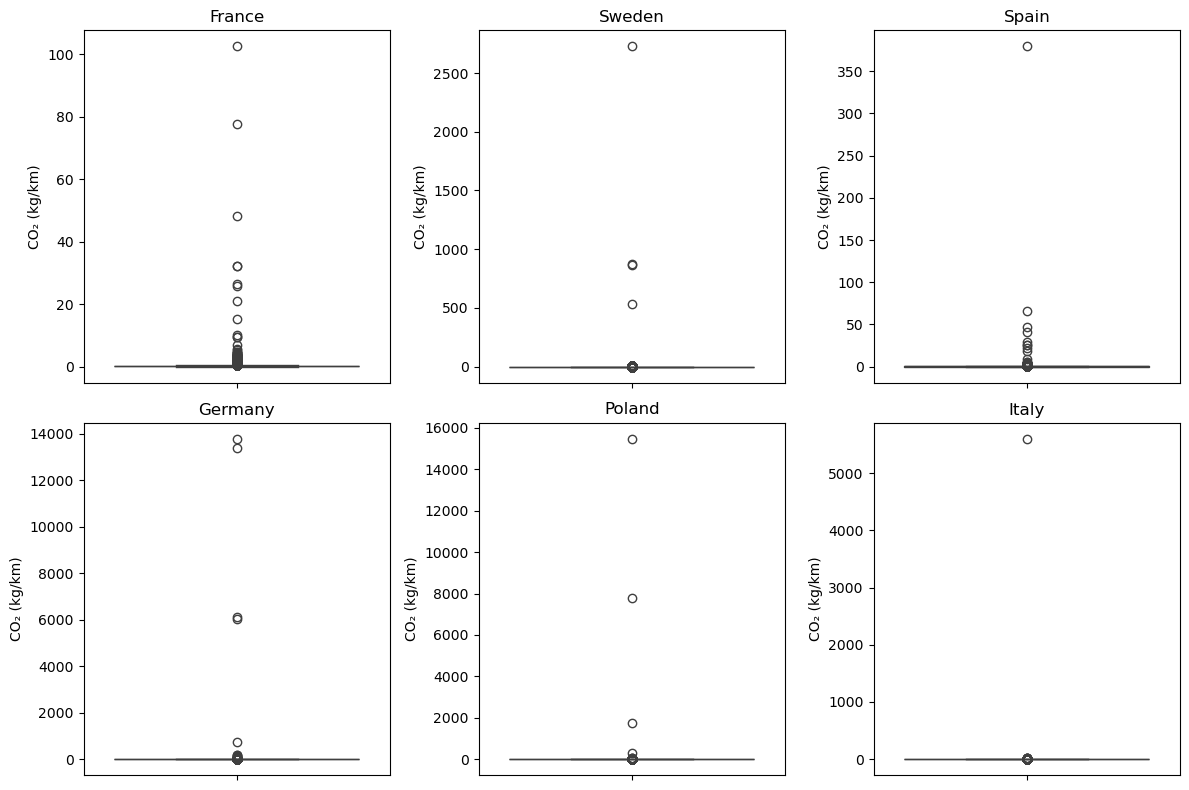

In [74]:
plt.figure(figsize=(12, 8))

for i, country in enumerate(selected_countries):
    plt.subplot(2, 3, i+1)  
    country_data = selected_phev_df[selected_phev_df['Country'] == country]
    sns.boxplot(data=country_data, y="Total_CO2_driving(kg/km)")
    plt.title(country)
    plt.ylabel("CO₂ (kg/km)")

plt.tight_layout()
plt.show()


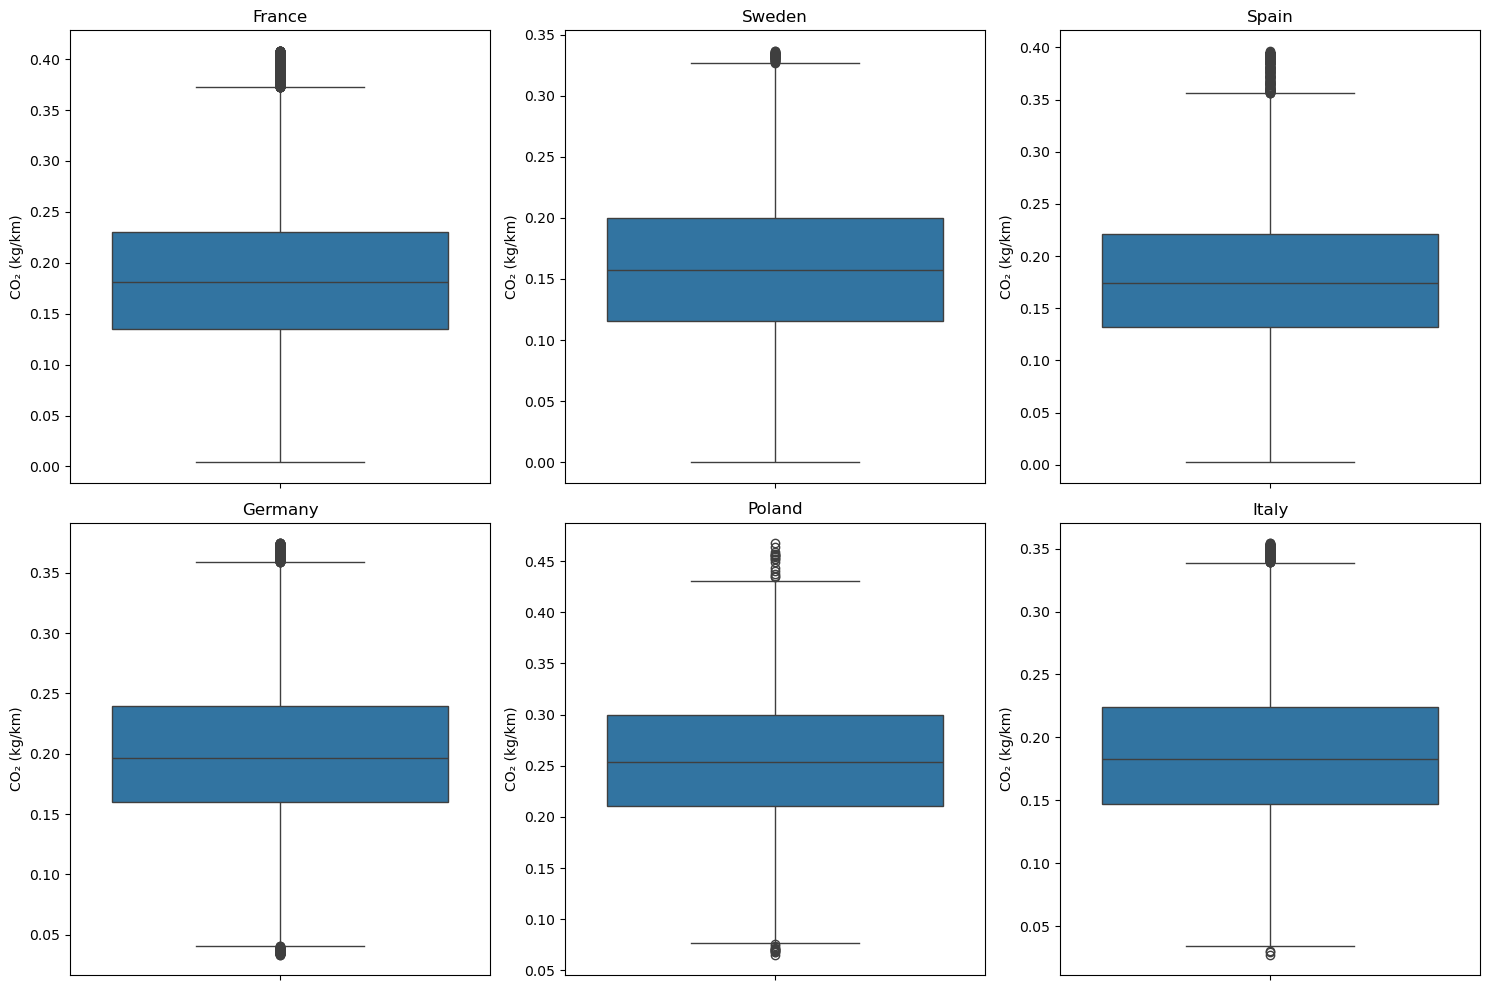

In [76]:
columns_to_clean = ["Total_CO2_driving(kg/km)"]  

# Create a clean dataframe by combining cleaned data from each country after removing outliers
cleaned_all_df2 = pd.DataFrame()

for country in selected_countries:
    country_df = selected_phev_df[selected_phev_df['Country'] == country]
    cleaned_country_df = remove_outliers(country_df, columns_to_clean)
    cleaned_all_df2 = pd.concat([cleaned_all_df2, cleaned_country_df], ignore_index=True)

# Plot separate boxplots for each country
plt.figure(figsize=(15, 10))

for i, country in enumerate(selected_countries):
    plt.subplot(2, 3, i+1)           
    country_data = cleaned_all_df2[cleaned_all_df2['Country'] == country]
    sns.boxplot(data=country_data, y="Total_CO2_driving(kg/km)")
    plt.title(country)
    plt.ylabel("CO₂ (kg/km)")

plt.tight_layout()
plt.show()



In [77]:
phev_df_clean = cleaned_all_df2.copy()

In [78]:
phev_df_clean.shape

(252407, 32)

In [79]:
# Aggregate mean CO2 emissions for Petrol and PHEV by country and merge into a single dataframe

petrol_country = petrol_df_clean.groupby("Country").agg({
                            'CO2_WTW(kg/km)':'mean'}).rename(columns={"CO2_WTW(kg/km)" : "Petrol CO2"}).reset_index()

phev_country = phev_df_clean.groupby("Country").agg({'Total_CO2_driving(kg/km)':'mean',
                                                     'Battery_CO2(kg)':'mean'}).rename(columns={"Total_CO2_driving(kg/km)": "PHEV_CO2",
                                                                                  "Battery_CO2(kg)": "PHEV_batt_CO2(kg)"}).reset_index()

country_pet_phev = pd.merge(petrol_country , phev_country, on="Country", how = 'inner')


In [80]:
country_pet_phev.sample(4)

,Country,Petrol CO2,PHEV_CO2,PHEV_batt_CO2(kg)
1,Germany,0.236764,0.202438,926.075359
3,Poland,0.217069,0.256025,1116.235123
2,Italy,0.306509,0.186724,740.132733
5,Sweden,0.197924,0.158132,824.730782


### Calculate the Break-eaven point for phev in selected countries

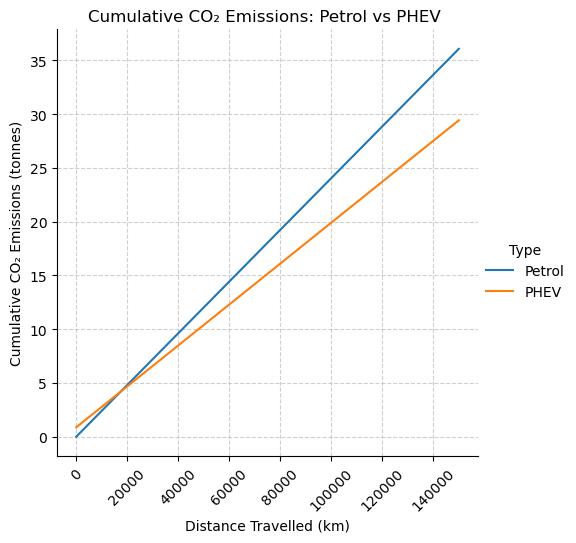

In [84]:
# Calculate the Break-eaven point for petrol and phev

km = np.linspace(0, 150000, 500)
rows = []

# Calculate average CO2 per km for petrol cars
petrol_CO2_per_km = petrol_df_clean['CO2_WTW(kg/km)'].mean()

# Calculate average CO2 per km for PHEV cars
phev_CO2_per_km = phev_df_clean['Total_CO2_driving(kg/km)'].mean()

# Calculate average battery production CO2 for PHEV cars
phev_battery_CO2 = phev_df_clean['Battery_CO2(kg)'].mean()

# Loop through each distance value
for k in km:
    rows.append({
        "Type": "Petrol",
        "Distance_km": k,
        "Cumulative_CO2_t": petrol_CO2_per_km * k / 1000 })

    
    rows.append({
        "Type": "PHEV",
        "Distance_km": k,
        "Cumulative_CO2_t": (phev_battery_CO2 + phev_CO2_per_km * k) / 1000  
    })

plot_df = pd.DataFrame(rows)            # Convert the list of rows into a DataFrame          

sns.relplot(
    data=plot_df,
    x="Distance_km",                    # X-axis: distance driven
    y="Cumulative_CO2_t",               # Y-axis: total CO2 emissions in tonnes
    hue="Type",                         # Color by car type (Petrol or PHEV)
    kind="line"                         
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Distance Travelled (km)")
plt.ylabel("Cumulative CO₂ Emissions (tonnes)")
plt.title("Cumulative CO₂ Emissions: Petrol vs PHEV ")
plt.xticks(rotation=45)
plt.show()

### How much PHEVs are used in full electric mode?

In [85]:
# Calculating the Electric usage ratio 

phev_df_clean['electric_usage_ratio'] = (
    phev_df_clean['Total distance travelled in charge depleting operation with engine off (lifetime) (km)'] /
    phev_df_clean['Total distance travelled (lifetime) (km)'])

phev_df_clean['electric_usage_ratio'] = phev_df_clean['electric_usage_ratio'].fillna(0)
phev_df_clean = phev_df_clean[phev_df_clean['electric_usage_ratio'] <= 1]

country_avg = phev_df_clean.groupby('Country').agg({'electric_usage_ratio':'mean'}).reset_index()

In [86]:
country_avg.loc[:,'electric_usage_ratio'] = country_avg['electric_usage_ratio']*100
country_avg

,Country,electric_usage_ratio
0,France,27.492675
1,Germany,31.597295
2,Italy,30.985463
3,Poland,33.644013
4,Spain,31.202089
5,Sweden,34.861439


In [87]:
country_avg = country_avg.sort_values(by='electric_usage_ratio', ascending=True)

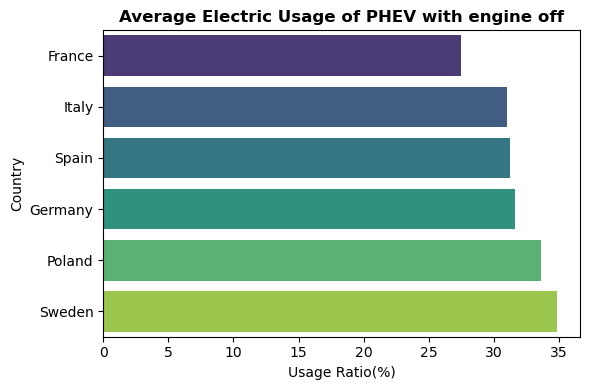

In [88]:
plt.figure(figsize=(6, 4))
sns.barplot(data=country_avg, y='Country', x='electric_usage_ratio', palette='viridis', hue='Country')
plt.title('Average Electric Usage of PHEV with engine off', fontsize=12, weight='bold')
plt.xlabel('Usage Ratio(%)')
plt.tight_layout()
plt.show()

---

# 6. Working on BEV (ev_df)
### Analysis of Fully Electric Vehicles
Data Source: [EV Database](https://ev-database.org) — raw data obtained via web scraping

#### 6.1. Extracting Energy Consumption of BEVs

In [89]:
# Web scraping: All-electric car energy consumption
# Source: EV Database - Energy consumption cheatsheet
# URL: https://ev-database.org/cheatsheet/energy-consumption-electric-car

url = "https://ev-database.org/cheatsheet/energy-consumption-electric-car"
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')
rows = table.find_all('tr')

data = []
for row in rows[1:]:
    cols = row.find_all('td')
    data.append([col.text.strip() for col in cols])

df = pd.DataFrame(data, columns=['Car', 'Consumption'])
ev_energy_df = df.copy()

In [90]:
ev_energy_df.shape

(527, 2)

In [91]:
ev_energy_df.head()

,Car,Consumption
0,Tesla Model 3 RWD,136
1,Tesla Model 3 Long Range RWD,136
2,Tesla Model 3 Long Range AWD,143
3,Mini Cooper E,146
4,Mini Cooper SE,149


#### 6.2. Extracting Battery Capacity of BEVs

In [92]:
# Web scraping: Usable battery capacity of all-electric cars
# Source: EV Database - Battery capacity cheatsheet
# URL: https://ev-database.org/cheatsheet/useable-battery-capacity-electric-car

url = "https://ev-database.org/cheatsheet/useable-battery-capacity-electric-car"
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')
rows = table.find_all('tr')

data = []
for row in rows[1:]: 
    cols = row.find_all('td')
    data.append([col.text.strip() for col in cols])

df2 = pd.DataFrame(data, columns=['Car', 'Battery Capacity (kWh)'])


In [93]:
ev_battery_df = df2.copy()

In [94]:
ev_battery_df.shape

(527, 2)

In [95]:
ev_battery_df.head()

,Car,Battery Capacity (kWh)
0,Lucid Gravity Grand Touring,123.00
1,Mercedes-Benz EQS SUV Maybach 680,118.00
2,Mercedes-Benz EQS SUV 450+,118.00
3,Mercedes-Benz EQS SUV 450 4MATIC,118.00
4,Mercedes-Benz EQS SUV 500 4MATIC,118.00


#### 6.3. Create the merged dataframe: Energy consumption df & Battery capacity df

In [96]:
# merging energy consumption dataframe and battery capacity dataframe

ev_df_combined = pd.merge(ev_energy_df, ev_battery_df, on='Car', how='inner')


In [97]:
ev_df_combined.head()

,Car,Consumption,Battery Capacity (kWh)
0,Tesla Model 3 RWD,136,60.50
1,Tesla Model 3 Long Range RWD,136,75.00
2,Tesla Model 3 Long Range AWD,143,75.00
3,Mini Cooper E,146,36.60
4,Mini Cooper SE,149,49.20


In [98]:
ev_df_combined.drop_duplicates().shape

(533, 3)

In [99]:
ev_df_combined.drop_duplicates(subset = 'Car').shape

(521, 3)

In [100]:
ev_df_combined = ev_df_combined.drop_duplicates(subset = 'Car')

In [101]:
ev_df_combined.shape

(521, 3)

In [102]:
ev_df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 521 entries, 0 to 538
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Car                     521 non-null    object
 1   Consumption             521 non-null    object
 2   Battery Capacity (kWh)  521 non-null    object
dtypes: object(3)
memory usage: 16.3+ KB


In [103]:
# Convert Consumption and Battery Capacity (kWh) into numeric

ev_df_combined["Consumption"] = pd.to_numeric(ev_df_combined["Consumption"], errors='coerce')
ev_df_combined["Battery Capacity (kWh)"] = pd.to_numeric(ev_df_combined["Battery Capacity (kWh)"], errors='coerce')


In [104]:
ev_df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 521 entries, 0 to 538
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Car                     521 non-null    object 
 1   Consumption             521 non-null    int64  
 2   Battery Capacity (kWh)  521 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 16.3+ KB


#### 6.4. CO2 emission due to battery production 

In [105]:
# Estimate CO2 emissions from battery production (kg CO2)
# Using global average ~80 kg CO2/kWh

ev_df_combined.loc[:,'EV_batt_CO2'] = ev_df_combined.loc[:,"Battery Capacity (kWh)"] * 80


In [106]:
ev_df_combined.head()

,Car,Consumption,Battery Capacity (kWh),EV_batt_CO2
0,Tesla Model 3 RWD,136,60.5,4840.0
1,Tesla Model 3 Long Range RWD,136,75.0,6000.0
2,Tesla Model 3 Long Range AWD,143,75.0,6000.0
3,Mini Cooper E,146,36.6,2928.0
4,Mini Cooper SE,149,49.2,3936.0


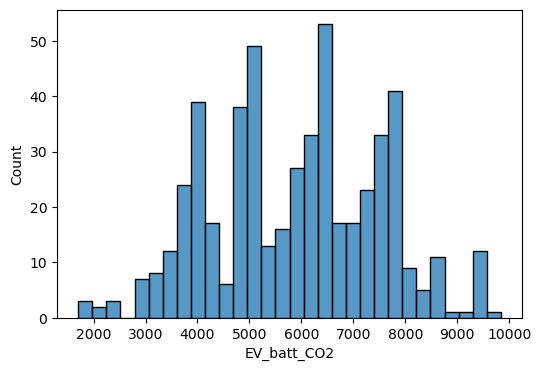

In [107]:
plt.figure(figsize=(6,4))
sns.histplot(data = ev_df_combined , x='EV_batt_CO2',bins=30);

In [108]:
ev_df_combined.shape

(521, 4)

In [109]:
col = ['Battery Capacity (kWh)']
remove_outliers(ev_df_combined, col ).shape

(521, 4)

In [110]:
col = ['EV_batt_CO2']
remove_outliers(ev_df_combined, col ).shape

(521, 4)

---

#### 6.5. CO2 emission due to Electricity Consumption
CO₂ Emission Factors for Electricity (g CO₂eq/kWh)
For selected countries: France, Sweden, Germany, Poland, 'Spain' and 'Italy'

| Country  | Code | Main Energy Sources             |
|----------|------|---------------------------------|
| France   | FR   | Nuclear, Renewables             |
| Sweden   | SE   | Hydro, Nuclear, Wind            |
| Spain	   | ES	  | Wind, Solar, Gas                |
| Germany  | DE   | Wind, Coal, Gas                 |
| Poland   | PL   | Coal, Gas, Low Renewables       |
| Italy    | IT   |	Gas, Hydro, Solar               |

In [111]:
electricity_emission_df_EU.loc[electricity_emission_df_EU['Code']=='DE']

,Code,Country,CO2_intensity(kg/kwh)
65,DE,Germany,0.420107


In [112]:
electricity_emission_df_EU

,Code,Country,CO2_intensity(kg/kwh)
8,AT,Austria,0.141063
15,BE,Belgium,0.139404
24,BG,Bulgaria,0.476333
40,HR,Croatia,0.244681
42,CY,Cyprus,0.555133
43,CZ,Czechia,0.488355
45,DK,Denmark,0.201200
55,EE,Estonia,0.487696
59,FI,Finland,0.129832
60,FR,France,0.078550


In [113]:
round(electricity_emission_df_EU.loc[electricity_emission_df_EU['Code'] == 'DE', 'CO2_intensity(kg/kwh)'].iloc[0] , 2)

0.42

In [114]:
selected_country = ['FR','SE','ES','DE','PL','IT']
for Code in selected_country:
    print(round(electricity_emission_df_EU.loc[electricity_emission_df_EU['Code'] == Code, 'CO2_intensity(kg/kwh)'].iloc[0],2))

0.08
0.04
0.22
0.42
0.73
0.38


In [115]:
# create s columns for each country in selected list

ev_selected_con_df= ev_df_combined.copy()
selected_country = ['FR', 'SE','ES','IT','DE', 'PL']

for Code in selected_country:
    emission_factor = round(electricity_emission_df_EU.loc[electricity_emission_df_EU['Code'] == Code, 'CO2_intensity(kg/kwh)'].iloc[0],2)
    
    ev_selected_con_df[f"E_CO2(kg/km)_{Code}"] = emission_factor * (ev_selected_con_df["Consumption"] / 1000)
    

In [116]:
ev_selected_con_df.head()

,Car,Consumption,Battery Capacity (kWh),EV_batt_CO2,E_CO2(kg/km)_FR,E_CO2(kg/km)_SE,E_CO2(kg/km)_ES,E_CO2(kg/km)_IT,E_CO2(kg/km)_DE,E_CO2(kg/km)_PL
0,Tesla Model 3 RWD,136,60.5,4840.0,0.01088,0.00544,0.02992,0.05168,0.05712,0.09928
1,Tesla Model 3 Long Range RWD,136,75.0,6000.0,0.01088,0.00544,0.02992,0.05168,0.05712,0.09928
2,Tesla Model 3 Long Range AWD,143,75.0,6000.0,0.01144,0.00572,0.03146,0.05434,0.06006,0.10439
3,Mini Cooper E,146,36.6,2928.0,0.01168,0.00584,0.03212,0.05548,0.06132,0.10658
4,Mini Cooper SE,149,49.2,3936.0,0.01192,0.00596,0.03278,0.05662,0.06258,0.10877


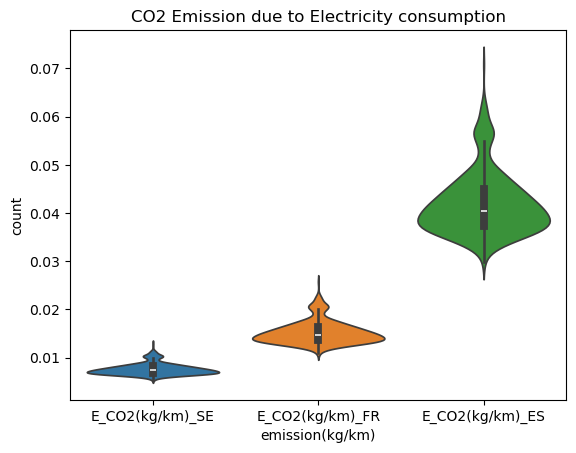

In [117]:

col = ['E_CO2(kg/km)_SE','E_CO2(kg/km)_FR','E_CO2(kg/km)_ES']
sns.violinplot(data=ev_selected_con_df[col])
plt.title('CO2 Emission due to Electricity consumption')
plt.xlabel('emission(kg/km)')
plt.ylabel('count');

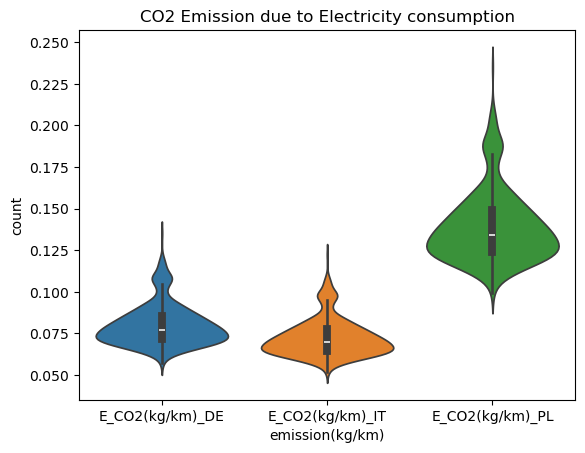

In [118]:
col = ['E_CO2(kg/km)_DE','E_CO2(kg/km)_IT','E_CO2(kg/km)_PL']
sns.violinplot(data=ev_selected_con_df[col])
plt.title('CO2 Emission due to Electricity consumption')
plt.xlabel('emission(kg/km)')
plt.ylabel('count');

In [119]:
# Befor removing outliers
ev_selected_con_df.shape

(521, 10)

In [120]:
# After removing outliers
remove_outliers(ev_selected_con_df, col ).shape

(481, 10)

In [121]:
# remove Outliers

col = ['E_CO2(kg/km)_SE','E_CO2(kg/km)_FR','E_CO2(kg/km)_ES','E_CO2(kg/km)_DE','E_CO2(kg/km)_IT','E_CO2(kg/km)_PL']
ev_df_clean = remove_outliers(ev_selected_con_df, col )

In [122]:
mean_values = ev_df_clean[col].mean().sort_values()

In [123]:
mean_values

E_CO2(kg/km)_SE    0.007366
E_CO2(kg/km)_FR    0.014732
E_CO2(kg/km)_ES    0.040513
E_CO2(kg/km)_IT    0.069976
E_CO2(kg/km)_DE    0.077342
E_CO2(kg/km)_PL    0.134428
dtype: float64

In [124]:
data = {
    'Sweden': 0.007358,
    'France': 0.014717,
    'Spain': 0.040471,
    'Italy': 0.069904,
    'Germany': 0.077263,
    'Poland': 0.134290
}

# Convert to a pandas Series
ev_mean_values = pd.DataFrame(list(data.items()) , columns= ['Country','BEV_CO2'])
ev_mean_values

,Country,BEV_CO2
0,Sweden,0.007358
1,France,0.014717
2,Spain,0.040471
3,Italy,0.069904
4,Germany,0.077263
5,Poland,0.134290


In [125]:
ev_mean_values = ev_mean_values.sort_values(by='BEV_CO2', ascending=False)

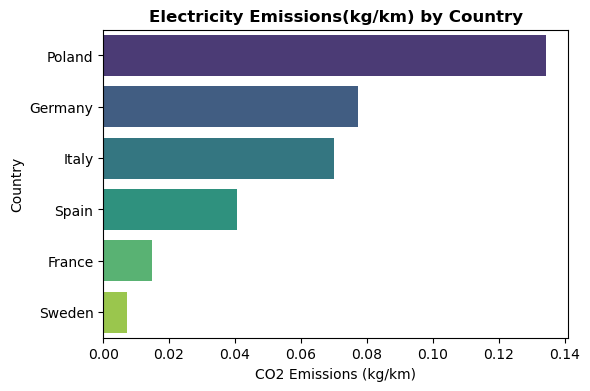

In [126]:

plt.figure(figsize = (6,4))
sns.barplot( data = ev_mean_values , x='BEV_CO2' , y='Country' , palette = 'viridis', hue='Country')
plt.title("Electricity Emissions(kg/km) by Country", fontsize=12, weight='bold')
plt.xlabel("CO2 Emissions (kg/km)")
plt.savefig("chart01.png", dpi=300, bbox_inches='tight')
plt.show()

In [127]:
country_pet_phev

,Country,Petrol CO2,PHEV_CO2,PHEV_batt_CO2(kg)
0,France,0.194489,0.185476,846.407269
1,Germany,0.236764,0.202438,926.075359
2,Italy,0.306509,0.186724,740.132733
3,Poland,0.217069,0.256025,1116.235123
4,Spain,0.206494,0.179367,864.455506
5,Sweden,0.197924,0.158132,824.730782


In [128]:
# Merge the final DataFrames from each section to create a single DataFrame containing all vehicles

all_vehicles_df = pd.merge(country_pet_phev , ev_mean_values, on='Country', how='inner' )


In [129]:
all_vehicles_df.loc[:,'EV_batt_CO2(kg)'] = int(ev_df_combined['EV_batt_CO2'].mean())
all_vehicles_df

,Country,Petrol CO2,PHEV_CO2,PHEV_batt_CO2(kg),BEV_CO2,EV_batt_CO2(kg)
0,France,0.194489,0.185476,846.407269,0.014717,5877
1,Germany,0.236764,0.202438,926.075359,0.077263,5877
2,Italy,0.306509,0.186724,740.132733,0.069904,5877
3,Poland,0.217069,0.256025,1116.235123,0.134290,5877
4,Spain,0.206494,0.179367,864.455506,0.040471,5877
5,Sweden,0.197924,0.158132,824.730782,0.007358,5877


In [130]:
int(ev_df_combined['EV_batt_CO2'].mean())

5877

In [131]:
green_countries_df = all_vehicles_df[all_vehicles_df['Country'].isin(['France','Spain','Sweden'])]

In [132]:
green_countries_df

,Country,Petrol CO2,PHEV_CO2,PHEV_batt_CO2(kg),BEV_CO2,EV_batt_CO2(kg)
0,France,0.194489,0.185476,846.407269,0.014717,5877
4,Spain,0.206494,0.179367,864.455506,0.040471,5877
5,Sweden,0.197924,0.158132,824.730782,0.007358,5877


In [133]:
coal_based_countries = all_vehicles_df[all_vehicles_df['Country'].isin(['Germany','Poland'])]

In [134]:
coal_based_countries

,Country,Petrol CO2,PHEV_CO2,PHEV_batt_CO2(kg),BEV_CO2,EV_batt_CO2(kg)
1,Germany,0.236764,0.202438,926.075359,0.077263,5877
3,Poland,0.217069,0.256025,1116.235123,0.134290,5877


### Calculate the Break-eaven point for BVs

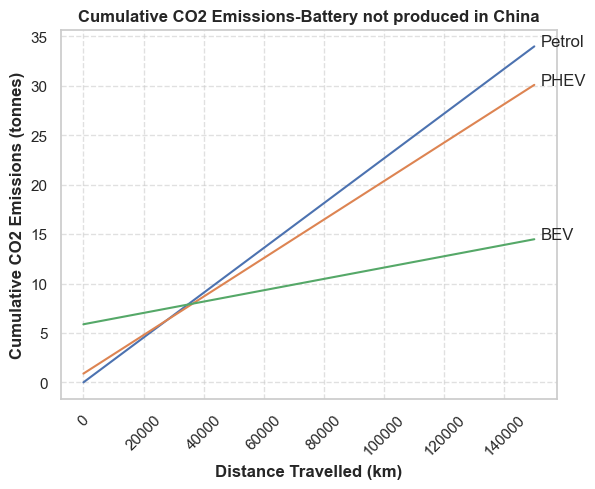

In [135]:
# Calculate the Break-eaven point for petrol,Bev and phev
# Battery not produced in China

km = np.linspace(0, 150000, 500)
rows = []

# Calculate average CO2 per km for petrol cars
petrol_CO2 = all_vehicles_df['Petrol CO2'].mean()

# Calculate average CO2 per km for PHEV cars
phev_CO2 = all_vehicles_df['PHEV_CO2'].mean()

# Calculate average battery production CO2 for PHEV cars
phev_batt_CO2 = all_vehicles_df['PHEV_batt_CO2(kg)'].mean()

# Calculate average CO2 per km for BEV cars
ev_CO2 = all_vehicles_df['BEV_CO2'].mean()

# Calculate average battery production CO2 for BEV cars
ev_battery_CO2 = all_vehicles_df['EV_batt_CO2(kg)'].mean()

# Loop through each distance value
for k in km:
    rows.append({
        "Type": "Petrol",
        "Distance_km": k,
        "Cumulative_CO2_t": petrol_CO2 * k / 1000 })

    
    rows.append({
        "Type": "PHEV",
        "Distance_km": k,
        "Cumulative_CO2_t": (phev_batt_CO2 + phev_CO2 * k) / 1000  
    })

    rows.append({
        "Type": "BEV",
        "Distance_km": k,
        "Cumulative_CO2_t": (ev_battery_CO2 + ev_CO2 * k) / 1000  
    })

plot_df = pd.DataFrame(rows)            # Convert the list of rows into a DataFrame          

sns.set_theme(style="whitegrid") 

sns.lineplot(
    data=plot_df,
    x="Distance_km",                    # X-axis: distance driven
    y="Cumulative_CO2_t",               # Y-axis: total CO2 emissions in tonnes
    hue="Type",                         # Color by car type (Petrol or PHEV)
                           
)

Types=["Petrol","PHEV","BEV"]
for car_type in Types:
    last_row = plot_df[plot_df['Type'] == car_type].iloc[-1]
    plt.text(
        x=last_row['Distance_km'] + 2000, 
        y=last_row['Cumulative_CO2_t'], 
        s=car_type
    )

plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Distance Travelled (km)",  weight='bold')
plt.ylabel("Cumulative CO2 Emissions (tonnes)",  weight='bold')
plt.title("Cumulative CO2 Emissions-Battery not produced in China", fontsize=12, weight='bold')
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)      # to remove legend
plt.savefig("chart02.png", dpi=300, bbox_inches='tight')
plt.show()

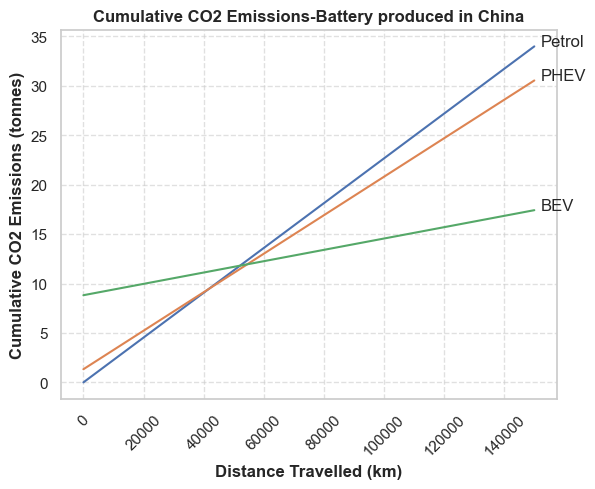

In [136]:
# Calculate the Break-eaven point for petrol,Bev and phev 
# Battery produced in China(high Li)

km = np.linspace(0, 150000, 500)
rows = []

# Calculate average CO2 per km for petrol cars
petrol_CO2_2 = all_vehicles_df['Petrol CO2'].mean()

# Calculate average CO2 per km for PHEV cars
phev_CO2_2 = all_vehicles_df['PHEV_CO2'].mean()

# Calculate average battery production CO2 for PHEV cars
phev_batt_CO2_2 = all_vehicles_df['PHEV_batt_CO2(kg)'].mean()

# Calculate average CO2 per km for BEV cars
ev_CO2_2 = all_vehicles_df['BEV_CO2'].mean()

# Calculate average battery production CO2 for BEV cars
ev_battery_CO2_2 = all_vehicles_df['EV_batt_CO2(kg)'].mean()

# Loop through each distance value
for k in km:
    rows.append({
        "Type": "Petrol",
        "Distance_km": k,
        "Cumulative_CO2_t": petrol_CO2_2 * k / 1000 })

    
    rows.append({
        "Type": "PHEV",
        "Distance_km": k,
        "Cumulative_CO2_t": ((1.5*phev_batt_CO2_2) + phev_CO2_2 * k) / 1000  
    })

    rows.append({
        "Type": "BEV",
        "Distance_km": k,
        "Cumulative_CO2_t": ((1.5*ev_battery_CO2_2) + ev_CO2_2 * k) / 1000  
    })

plot_df_2 = pd.DataFrame(rows)            # Convert the list of rows into a DataFrame          

sns.set_theme(style="whitegrid") 

sns.lineplot(
    data=plot_df_2,
    x="Distance_km",                    # X-axis: distance driven
    y="Cumulative_CO2_t",               # Y-axis: total CO2 emissions in tonnes
    hue="Type",                         # Color by car type (Petrol or PHEV)
                           
)

Types=["Petrol","PHEV","BEV"]
for car_type in Types:
    last_row = plot_df_2[plot_df_2['Type'] == car_type].iloc[-1]
    plt.text(
        x=last_row['Distance_km'] + 2000, 
        y=last_row['Cumulative_CO2_t'], 
        s=car_type
    )

plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Distance Travelled (km)", weight='bold')
plt.ylabel("Cumulative CO2 Emissions (tonnes)", weight='bold')
plt.title("Cumulative CO2 Emissions-Battery produced in China", fontsize=12, weight='bold')
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)      # to remove legend
plt.savefig("chart03.png", dpi=300, bbox_inches='tight')
plt.show()

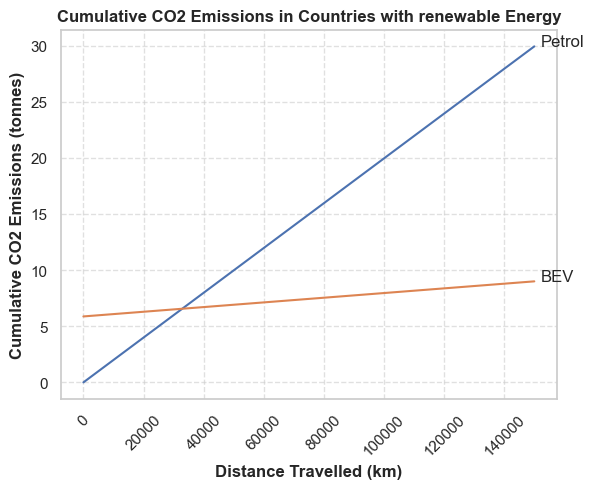

In [137]:
# Calculate the Break-eaven point for petrol,Bev and phev 
# in green Countries

km = np.linspace(0, 150000, 500)
rows = []

# Calculate average CO2 per km for petrol cars
petrol_CO2 = green_countries_df['Petrol CO2'].mean()

# Calculate average CO2 per km for PHEV cars
phev_CO2 = green_countries_df['PHEV_CO2'].mean()

# Calculate average battery production CO2 for PHEV cars
phev_batt_CO2 = green_countries_df['PHEV_batt_CO2(kg)'].mean()

# Calculate average CO2 per km for BEV cars
ev_CO2 = green_countries_df['BEV_CO2'].mean()

# Calculate average battery production CO2 for BEV cars
ev_battery_CO2 = green_countries_df['EV_batt_CO2(kg)'].mean()

# Loop through each distance value
for k in km:
    rows.append({
        "Type": "Petrol",
        "Distance_km": k,
        "Cumulative_CO2_t": petrol_CO2 * k / 1000 })

    
    # rows.append({
    #     "Type": "PHEV",
    #     "Distance_km": k,
    #     "Cumulative_CO2_t": (phev_batt_CO2 + phev_CO2 * k) / 1000  
    # })

    rows.append({
        "Type": "BEV",
        "Distance_km": k,
        "Cumulative_CO2_t": (ev_battery_CO2 + ev_CO2 * k) / 1000  
    })

plot_df_green = pd.DataFrame(rows)            # Convert the list of rows into a DataFrame          

sns.set_theme(style="whitegrid") 

sns.lineplot(
    data=plot_df_green,
    x="Distance_km",                    # X-axis: distance driven
    y="Cumulative_CO2_t",               # Y-axis: total CO2 emissions in tonnes
    hue="Type",                         # Color by car type (Petrol or PHEV)
                           
)

Types=["Petrol","BEV"]
for car_type in Types:
    last_row = plot_df_green[plot_df_green['Type'] == car_type].iloc[-1]
    plt.text(
        x=last_row['Distance_km'] + 2000, 
        y=last_row['Cumulative_CO2_t'], 
        s=car_type
    )

plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Distance Travelled (km)",  weight='bold')
plt.ylabel("Cumulative CO2 Emissions (tonnes)" ,  weight='bold')
plt.title("Cumulative CO2 Emissions in Countries with renewable Energy", fontsize=12, weight='bold')
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)      # to remove legend
plt.savefig("chart04.png", dpi=300, bbox_inches='tight')
plt.show()

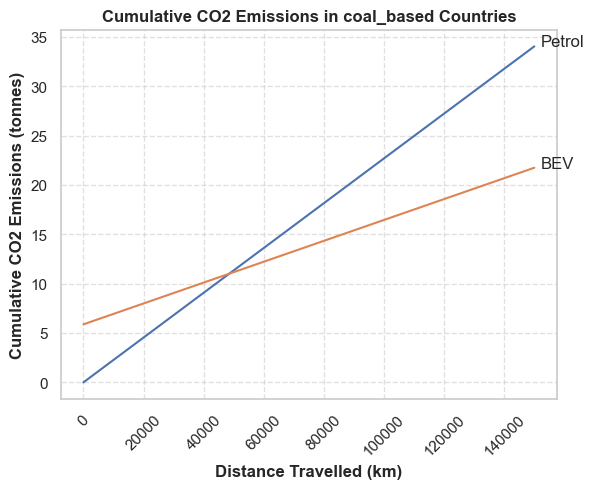

In [138]:
# Calculate the Break-eaven point for petrol,Bev and phev 
# in coal based Countries 

km = np.linspace(0, 150000, 500)
rows = []

# Calculate average CO2 per km for petrol cars
petrol_CO2 = coal_based_countries['Petrol CO2'].mean()

# Calculate average CO2 per km for PHEV cars
phev_CO2 = coal_based_countries['PHEV_CO2'].mean()

# Calculate average battery production CO2 for PHEV cars
phev_batt_CO2 = coal_based_countries['PHEV_batt_CO2(kg)'].mean()

# Calculate average CO2 per km for BEV cars
ev_CO2 = coal_based_countries['BEV_CO2'].mean()

# Calculate average battery production CO2 for BEV cars
ev_battery_CO2 = coal_based_countries['EV_batt_CO2(kg)'].mean()

# Loop through each distance value
for k in km:
    rows.append({
        "Type": "Petrol",
        "Distance_km": k,
        "Cumulative_CO2_t": petrol_CO2 * k / 1000 })

    
    # rows.append({
    #     "Type": "PHEV",
    #     "Distance_km": k,
    #     "Cumulative_CO2_t": (phev_batt_CO2 + phev_CO2 * k) / 1000  
    # })

    rows.append({
        "Type": "BEV",
        "Distance_km": k,
        "Cumulative_CO2_t": (ev_battery_CO2 + ev_CO2 * k) / 1000  
    })

plot_df_not_green = pd.DataFrame(rows)            # Convert the list of rows into a DataFrame          

sns.set_theme(style="whitegrid") 

sns.lineplot(
    data=plot_df_not_green,
    x="Distance_km",                    # X-axis: distance driven
    y="Cumulative_CO2_t",               # Y-axis: total CO2 emissions in tonnes
    hue="Type",                         # Color by car type (Petrol or PHEV)
                           
)

Types=["Petrol","BEV"]
for car_type in Types:
    last_row = plot_df_not_green[plot_df_not_green['Type'] == car_type].iloc[-1]
    plt.text(
        x=last_row['Distance_km'] + 2000, 
        y=last_row['Cumulative_CO2_t'], 
        s=car_type
    )

plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Distance Travelled (km)",  weight='bold')
plt.ylabel("Cumulative CO2 Emissions (tonnes)" ,  weight='bold')
plt.title("Cumulative CO2 Emissions in coal_based Countries", fontsize=12, weight='bold')
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)      # to remove legend
plt.savefig("chart05.png", dpi=300, bbox_inches='tight')
plt.show()